   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

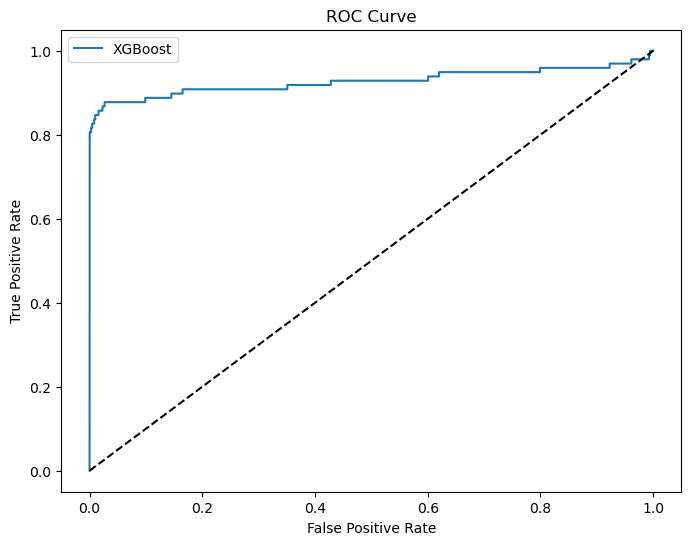

ROC AUC Score: 0.9268201143006443


In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib

# Load the dataset
df = pd.read_csv("C:\\Users\\siril\\OneDrive\\Documents\\MSME\\CreditcardFraudDetection\\creditcard.csv")
print(df.head())

# Check class distribution
print(df['Class'].value_counts())

# Normalize 'Amount'
scaler = StandardScaler()
df['normAmount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Splitting the dataset
X = df.drop('Class', axis=1)
y = df['Class']

# Anomaly detection using Isolation Forest
iso = IsolationForest(contamination=0.0017)
y_pred_iso = iso.fit_predict(X)
outliers_iso = np.where(y_pred_iso == -1)

print("Isolation Forest Outliers:", len(outliers_iso[0]))

# Anomaly detection using LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.0017)
y_pred_lof = lof.fit_predict(X)
outliers_lof = np.where(y_pred_lof == -1)

print("LOF Outliers:", len(outliers_lof[0]))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train XGBoost
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

# Save the model
joblib.dump(xgb, "model.pkl")

# Evaluation
y_pred = xgb.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# ROC Curve
y_probs = xgb.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='XGBoost')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("ROC AUC Score:", roc_auc_score(y_test, y_probs))
